# SD211 TP - Systèmes de recommandation

<p>Author: Rui SONG</p>
<p>Date: 5 mai 2017</p>

## Imports et Initialisations

In [1]:
#from movielens_utils import*
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import svds
from scipy.optimize import check_grad
import time
from scipy.optimize import line_search
import sys

rho = 0.2
C = [0,1,2,3,4,5,6]

## 1. Présentation du modèle

### Question 1.1

In [2]:
def load_movielens(filename, minidata=False):
    """
    Cette fonction lit le fichier filename de la base de donnees
    Movielens, par exemple 
    filename = '~/datasets/ml-100k/u.data'
    Elle retourne 
    R : une matrice utilisateur-item contenant les scores
    mask : une matrice valant 1 si il y a un score et 0 sinon
    """

    data = np.loadtxt(filename, dtype=int)

    R = sparse.coo_matrix((data[:, 2], (data[:, 0]-1, data[:, 1]-1)),
                          dtype=float)
    R = R.toarray()  # not optimized for big data

    # code la fonction 1_K
    mask = sparse.coo_matrix((np.ones(data[:, 2].shape),
                              (data[:, 0]-1, data[:, 1]-1)), dtype=bool )
    mask = mask.toarray()  # not optimized for big data

    if minidata is True:
        R = R[0:100, 0:200].copy()
        mask = mask[0:100, 0:200].copy()

    return R, mask

filename = "ml-100k/u.data"
R, mask = load_movielens(filename)

print R.shape

R_mini, mask_mini = load_movielens(filename, minidata=True)
print R_mini.shape, mask_mini.shape

(943, 1682)
(100, 200) (100, 200)


Si 'minidata' vaut 'True', le 'R' et le 'mark' retourné par la fonction 'load_movielens' sont les premières (100, 200) données dans le fichier u.data.

### Question 1.2

In [3]:
print np.sum(mask)

100000


Il y a 943 utilisateurs, 1682 films référencés, et le nombre total de notes est 100000.

### Question 1.3

<p>On traite la matrice comme un nombre réel et trouvera un contre-exemple. </p>
La fonction objectif est devenu:
$$f(P,Q) = \frac{1}{2}\parallel 1_{K}\circ (R-QP)\parallel _{F}^{2} + \frac{\rho}{2}\parallel Q\parallel _{F}^{2} + \frac{\rho}{2}\parallel Q\parallel _{F}^{2}$$
On trace la figure 3D de la fonction $f(x,y)=\frac{1}{2}(1-xy)^{2} + \frac{\rho}{2}x^{2} + \frac{\rho}{2}y^{2}$ comme ci-dessous:

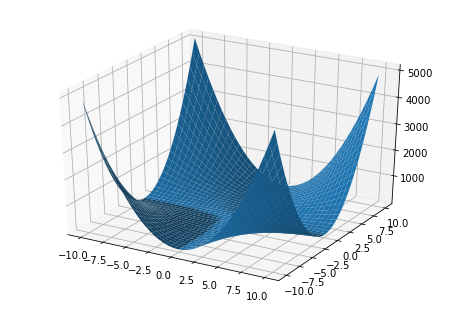

In [4]:
rol = 1e-5
x = np.linspace(-10, 10, 201)
y = np.linspace(-10, 10, 201)
X, Y = np.meshgrid(x, y)
fxy = ((1-X*Y)**2 + rol*(X**2) + rol*(Y**2))/2.

plt.close('all')
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, fxy)
plt.show()

On choisit deux point $p_{1}$ et $p_{2}$ dont coordonées sont (-10,0) et (0,-10). Donc, si la fonction objectif est convexe, on aura: $f(\frac{-10+0}{2},\frac{0+(-10)}{2})=f(-5,-5)\leq \frac{1}{2}f(-10,0)+\frac{1}{2}f(0,-10)$

In [5]:
print "f(-10,0) = %f" %fxy[100,0]
print "f(0,-10) = %f" %fxy[0,100]
print "f(-5,-5) = %f" %fxy[50,50]

f(-10,0) = 0.500500
f(0,-10) = 0.500500
f(-5,-5) = 288.000250


Au vue du résultat ci-dessus, on a $f(-5,-5)> \frac{1}{2}f(-10,0)+\frac{1}{2}f(0,-10)$. Donc, la fonction objectif n'est pas convexe.

<p>En suite, on calcule:</p>
$$\bigtriangledown_{P} f(P,Q) = -Q^{T}(1_{K}\circ (R-QP)) + \rho P$$
$$\bigtriangledown_{Q} f(P,Q) = -(1_{K}\circ (R-QP))P^{T} + \rho Q$$
On remplit la fonction 'total_objective' comme ci-dessous:

In [6]:
def total_objective(P, Q, R, mask, rho):
    """
    La fonction objectif du probleme complet.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q : la variable matricielle de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    grad_Q : le gradient par rapport a Q
    """

    tmp = (R - Q.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q ** 2) + np.sum(P ** 2))

    grad_P = -Q.T.dot(tmp) + rho*P  # todo

    grad_Q = -tmp.dot(P.T) + rho*Q  # todo

    return val, grad_P, grad_Q

Il n'est pas lipschitzien.

## 2. Trouve $P$ quand $Q_{0}$ est fixé

### Question 2.1

La fonction objectif simplifiée $g$ est convexe, parce que $\bigtriangledown^{2}g = (Q^{0})^{T}Q^{0} + \rho I$ est définie positive.

Son gradient est: 
$$\bigtriangledown g = -(Q^{0})^{T}(1_{K}\circ (R-Q^{0}P)) + \rho P$$

### Question 2.2

On remplit la fonction 'objective' comme ci-dessous:

In [7]:
def objective(P, Q0, R, mask, rho):
    """
    La fonction objectif du probleme simplifie.
    Prend en entree 
    P : la variable matricielle de taille C x I
    Q0 : une matrice de taille U x C
    R : une matrice de taille U x I
    mask : une matrice 0-1 de taille U x I
    rho : un reel positif ou nul

    Sorties :
    val : la valeur de la fonction
    grad_P : le gradient par rapport a P
    """

    tmp = (R - Q0.dot(P)) * mask

    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))

    grad_P = -Q0.T.dot(tmp) + rho*P  # todo

    return val, grad_P

En suite, on vérifie le calcul avec la fonction scipy.optimize.check_grad:

In [8]:
CC=len(C)
u, s, vt= svds(R,k=CC, return_singular_vectors=True)
def func(P, Q0, R, mask, rho):
    P = P.reshape(CC,-1)
    val, grad_P = objective(P, Q0, R, mask, rho)
    return val

def grad(P, Q0, R, mask, rho):
    P = P.reshape(CC,-1)
    val, grad_P = objective(P, Q0, R, mask, rho)
    return grad_P.ravel()

check_grad(func, grad, np.random.randn(CC, R.shape[1]).ravel(order='C'),u,R,mask,rho)

1.3949795751506171

### Question 2.3   Méthode du gradient  à pas constant

In [9]:
def gradient(g, P0, gamma, epsilon, Q0, R, mask, rho):
    val, grad_P = g(P0, Q0, R, mask, rho)
    grad_P_F = np.sqrt(np.sum(grad_P ** 2))
    k = 0
    while(grad_P_F > epsilon):
        P0 = P0 - gamma * grad_P
        val, grad_P = g(P0, Q0, R, mask, rho)
        grad_P_F = np.sqrt(np.sum(grad_P ** 2))
        k = k + 1
    return val, P0,k

### Question 2.4

In [10]:
CC=len(C)
u, s, vt= svds(R, k=CC, return_singular_vectors=True)
t0 = time.time()
L = rho + np.sqrt(np.sum((u.T.dot(u))**2))
gamma = 1.0/L
val, Pk, k = gradient(objective, np.zeros((CC, R.shape[1])), gamma, 1, u, R, mask, rho)
t1 = time.time()
print "The minimum value of the objective function is %f" %(val)
print "Minimum found in %f seconds, after %d iterations." %(t1 - t0, k)

The minimum value of the objective function is 297828.942767
Minimum found in 0.504618 seconds, after 46 iterations.


## 3. Raffinements algorithmiques pour le problème à $Q_{0}$ fixé

### Question 3.1  Méthode du gradient avec recherche linéaire

In [11]:
def armijo(g, P0, epsilon, Q0, R, mask, rho):
    a = 0.5
    b = 0.5
    beta = 0.5
    
    val, grad_P = g(P0, Q0, R, mask, rho)
    grad_P_F_2 = np.sum(grad_P ** 2)
    #grad_P_F = np.sqrt(grad_P_F_2)
    
    k = 0
    while(grad_P_F_2 > epsilon**2):
        gamma = b
        Pk_ = P0 - gamma*grad_P
        while(np.sum(((R-Q0.dot(Pk_))*mask)**2)/2.+rho/2.*(np.sum(Q0**2)+np.sum(Pk_**2)) > val-beta*gamma*grad_P_F_2):
            gamma = gamma * a
            Pk_ = P0 - gamma*grad_P
        P0 = Pk_
        b = 2 * gamma
        val, grad_P = g(P0, Q0, R, mask, rho)
        grad_P_F_2 = np.sum(grad_P ** 2)
        #grad_P_F = np.sqrt(grad_P_F_2)
        k = k + 1
    return val, P0, k

In [12]:
CC=len(C)
u, s, vt= svds(R, k=CC, return_singular_vectors=True)
t0 = time.time()
val, Pk, k = armijo(objective, np.zeros((CC, R.shape[1])), 1, u, R, mask, rho)
t1 = time.time()
print "The minimum value of the objective function is %f" %(val)
print "Minimum found in %f seconds, after %d iterations." %(t1 - t0, k)

The minimum value of the objective function is 297827.821785
Minimum found in 0.295246 seconds, after 10 iterations.


### Question 3.2  Méthode du gradient conjugué

In [13]:
def func(P, Q0, R, mask, rho):
    P = P.reshape(CC,-1)
    tmp = (R - Q0.dot(P)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P ** 2))
    return val

def grad(P, Q0, R, mask, rho):
    P = P.reshape(CC,-1)
    tmp = (R - Q0.dot(P)) * mask
    grad_P = -Q0.T.dot(tmp) + rho*P
    return grad_P.ravel()

def conjuguate(g, P0, epsilon, Q0, R, mask, rho):
    tmp = (R - Q0.dot(P0)) * mask
    grad_P = -Q0.T.dot(tmp) + rho*P0
    grad_P_sqrt = np.sum(grad_P ** 2)
    k = 0
    pk = -grad_P
    while(grad_P_sqrt > epsilon**2):
        alpha, fc, gc, nfval, ofval, ns = line_search(func, grad, xk=P0.ravel(), pk=pk.ravel(), args = (Q0,R,mask,rho))
        P0 = P0 + alpha*pk       
        tmp = (R - Q0.dot(P0)) * mask
        grad_P = -Q0.T.dot(tmp) + rho*P0
        grad_P_sqrt_post = np.sum(grad_P ** 2)
        beta = grad_P_sqrt_post/grad_P_sqrt
        pk = -grad_P + beta * pk
        grad_P_sqrt = grad_P_sqrt_post
        k = k + 1
        
    tmp = (R - Q0.dot(P0)) * mask
    val = np.sum(tmp ** 2)/2. + rho/2. * (np.sum(Q0 ** 2) + np.sum(P0 ** 2))
    return val, P0, k

In [14]:
CC=len(C)
u, s, vt= svds(R, k=CC, return_singular_vectors=True)
t0 = time.time()
val, Pk, k = conjuguate(objective, np.zeros((CC, R.shape[1])), 1, u, R, mask, rho)
t1 = time.time()
print "The minimum value of the objective function is %f" %(val)
print "Minimum found in %f seconds, after %d iterations." %(t1 - t0, k)

The minimum value of the objective function is 297827.645759
Minimum found in 0.488309 seconds, after 10 iterations.


### Question 3.3

<p>Parmi les trois algorithmes, la méthode du gradient conjugué atteint le meuilleure performance avec moins d'itérations pour trouver le minimum. Et le minimum trouvé par la méthode du gradient conjugué est aussi le plus petit parmi celui trouvé par les deux autres algorithmes.</p>
<p>La performance de la méthode du gradient avec recherche linéaire est meuilleure que celle de la méthode du gradient à pas constant.</p>

## 4. Résolution du problème complet

### Question 4.1

In [15]:
def total_objective_vectorized(PQvec, R, mask, rho):
    """
    Vectorisation de la fonction precedente de maniere a ne pas
    recoder la fonction gradient
    """

    # reconstruction de P et Q
    n_items = R.shape[1]
    n_users = R.shape[0]
    F = PQvec.shape[0] / (n_items + n_users)
    Pvec = PQvec[0:n_items*F]
    Qvec = PQvec[n_items*F:]
    P = np.reshape(Pvec, (F, n_items))
    Q = np.reshape(Qvec, (n_users, F))

    val, grad_P, grad_Q = total_objective(P, Q, R, mask, rho)
    return val, np.concatenate([grad_P.ravel(), grad_Q.ravel()])

def armijo_total(g, P0, epsilon, R, mask, rho):
    a = 0.5
    b = 0.5
    beta = 0.5
    
    val, grad_P = g(P0, R, mask, rho)
    grad_P_F_2 = np.sum(grad_P ** 2)
    
    k = 0
    while(grad_P_F_2 > epsilon**2):
        gamma = b
        Pk_ = P0 - gamma*grad_P
        valk, gradk = g(Pk_, R, mask, rho)
        while(valk > val-beta*gamma*grad_P_F_2):
            gamma = gamma * a
            Pk_ = P0 - gamma*grad_P
            valk, gradk = g(Pk_, R, mask, rho)
        P0 = Pk_
        b = 2 * gamma
        val = valk
        grad_P = gradk
        grad_P_F_2 = np.sum(gradk ** 2)
        k = k + 1
    return val, P0, k

In [16]:
CC=len(C)
u, s, vt= svds(R, k=CC, return_singular_vectors=True)
t0 = time.time()
val_linear, Pk, k = armijo_total(total_objective_vectorized, np.concatenate([vt.ravel(), u.ravel()]), 100, R, mask, rho)
n_items = R.shape[1]
n_users = R.shape[0]
F = Pk.shape[0] / (n_items + n_users)
Pvec = Pk[0:n_items*F]
Qvec = Pk[n_items*F:]
P_linear = np.reshape(Pvec, (F, n_items))
Q_linear = np.reshape(Qvec, (n_users, F))
t1 = time.time()
t_linear = t1 - t0
print "The minimum value of the objective function is %f" %(val_linear)
print "Minimum found in %f seconds, after %d iterations." %(t1 - t0, k)

The minimum value of the objective function is 31251.876721
Minimum found in 6.676611 seconds, after 165 iterations.


### Question 4.2

<p>Comme prouvé dans la question 2.1, quand $Q^{0}$ (respectivement, $P^{0}$) est fixé, la fonction objectif simplifiée est convexe. Donc la valeur de l'objectif va décoire à chacune des deux étapes de l'itération. Alors, la valeur de l’objectif dérôıt définitivement à chaque itération.</p>
<p>L'objectif est borné (dont valeur est superieure ou équal à 0), de plus, la valeur de l’objectif décrôit définitivement à chaque itération, alors elle converge<p/>

### Question 4.3

Inspiré par <a href="http://download.springer.com/static/pdf/467/chp%253A10.1007%252F978-3-540-68880-8_32.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Fchapter%2F10.1007%2F978-3-540-68880-8_32&token2=exp=1494534110~acl=%2Fstatic%2Fpdf%2F467%2Fchp%25253A10.1007%25252F978-3-540-68880-8_32.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Fchapter%252F10.1007%252F978-3-540-68880-8_32*~hmac=2611e17e4bf70ef88db060f2b597d6aaefb7b899ec800d001de347e63ae2414d">[ZWSP08] </a>, on peut déduire les solutions analytiques de $P_{k}$ et $Q_{k}$ dans chaque itération de la méthode de moindre carrés alternes:
<p>$p_{i} = (Q_{K_{i}}Q_{K_{i}}^{T}+\rho I)^{-1}Q_{K_{i}}R(K_{i}, i)$, 
</p><p>où $p_{i}$ est la i-ème colonne de $P_{k}$ dans l'itération $k$, $K_{i}$ est, pour un certain film $i$, l'ensemble de couple $(u,i)\in K$ pour lesquels $R_{u,i}$ est connu, et $R(K_{i}, i)$ est l'ensemble d'éléments de la i-ème colonne de la matrice $R$ dont valeurs n'est pas zéro.</p>
<p>Respectivement, $q_{u} = (P_{K_{u}}P_{K_{u}}^{T}+\rho I)^{-1}P_{K_{u}}R(u, K_{u})$, 
</p><p>où $q_{u}$ est la u-ème ligne de $Q_{k}$dans l'itération $k$, $K_{u}$ est, pour un certain utilisateur $u$, l'ensemble de couple $(u,i)\in K$ pour lesquels $R_{u,i}$ est connu, et $R(u, K_{u})$ est l'ensemble d'éléments de la u-ème ligne de la matrice $R$ dont valeurs n'est pas zéro.</p>
<p>Le code s'écrit comme ci-dessus:</p>

In [17]:
def AlternatingLeastSquares(P, Q, epsilon, R, mask, rho):
    U, I = R.shape
    dval = sys.float_info.max
    val = sys.float_info.max
    k = 0
    while(dval > epsilon):
        for i in range(I):
            K_i = mask[:, i].ravel()
            R_i = R[K_i, i]
            Q_i = Q[K_i, :]
            P[:, i] = np.linalg.solve(Q_i.T.dot(Q_i) + rho*np.identity(CC), Q_i.T.dot(R_i))
        for u in range(U):
            K_u = mask[u, :].ravel()
            R_u = R[u, K_u]
            P_u = P[:, K_u]
            Q[u, :] = np.linalg.solve(P_u.dot(P_u.T) + rho*np.identity(CC), P_u.dot(R_u.T))
        val_post = np.sum((mask*(R - Q.dot(P)))**2)/2. + rho/2.*(np.sum(Q**2) + np.sum(P**2))
        dval = val - val_post
        val = val_post
        k = k + 1
    return val, P, Q, k

In [18]:
CC=len(C)
u, s, vt= svds(R, k=CC, return_singular_vectors=True)
t0 = time.time()
val_ALS, P_ALS, Q_ALS, k = AlternatingLeastSquares(vt, u, 1, R, mask, rho)
t1 = time.time()
t_ALS = t1 - t0
print "The minimum value of the objective function is %f" %(val_ALS)
print "Minimum found in %f seconds, after %d iterations." %(t1 - t0, k)

The minimum value of the objective function is 28663.328313
Minimum found in 35.265298 seconds, after 268 iterations.


### Question 4.4

Les solutions ne sont pas les mêmes.

In [19]:
R_linear = Q_linear.dot(P_linear)
R_ALS = Q_ALS.dot(P_ALS)
print np.allclose(R_linear, R_ALS)

False


La prédiction n'est pas la même.

In [20]:
print "The minimum value found by using Linear Search methode is: %f" %(val_linear)
print "The minimum value found by using Alternating Least Squares methode is: %f" %(val_ALS)

The minimum value found by using Linear Search methode is: 31251.876721
The minimum value found by using Alternating Least Squares methode is: 28663.328313


La valeur de l'objectif n'est pas la même.

In [21]:
print "The time for Linear Search methode is: %f" %(t_linear)
print "The time for Alternating Least Squares methode is: %f" %(t_ALS)

The time for Linear Search methode is: 6.676611
The time for Alternating Least Squares methode is: 35.265298


Le temps pour la méthode des moindre carrés alternés est plus que celui pour la méthode du gradient avec recherche linéaire.

### Question 4.5

In [22]:
noteUser = R_ALS[449, :].reshape(-1)
print "The film recommended for User 449 is: %d" %(np.argmax(noteUser))

The film recommended for User 449 is: 317


## Références

[ZWSP08] Zhou Y, Wilkinson D, Schreiber R, et al. Large-scale parallel collaborative filtering for the netflix prize[C]//International Conference on Algorithmic Applications in Management. Springer Berlin Heidelberg, 2008: 337-348.